In [291]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import qutip
import scqubits
from IPython.display import clear_output
import matplotlib as mpl

import sys
sys.path.append('../')
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [238]:
def check_repeats(arr):
    flattened = arr.flatten()
    unique_elements, counts = np.unique(flattened, return_counts=True)
    duplicates = unique_elements[counts > 1]    
    return len(duplicates) > 0, duplicates

In [385]:
max_ql = 30
max_ol = 100
EJ = 3
EC = EJ/4
EL = EJ/20.5
Er = 8.46111172

g = 0.2
system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '1,2',
                ) 

import scqubits.utils
import scqubits.utils.spectrum_utils as spec_utils
op_callable_or_tuple = system.osc.annihilation_operator
if isinstance(op_callable_or_tuple, tuple):
    op, subsys = op_callable_or_tuple
    op_in_bare_eigenbasis = False
    subsys_index = system.hilbertspace.get_subsys_index(subsys)
else:
    assert callable(op_callable_or_tuple)
    op = op_callable_or_tuple
    op_in_bare_eigenbasis = False
    subsys_index = system.hilbertspace.get_subsys_index(op.__self__)
bare_evecs = system.hilbertspace._data["bare_evecs"][subsys_index][0]
id_wrapped_op = spec_utils.identity_wrap(
    op,
    system.hilbertspace.subsystem_list[subsys_index],
    system.hilbertspace.subsystem_list,
    op_in_eigenbasis=op_in_bare_eigenbasis,
    evecs=bare_evecs,
)

In [386]:
def plot_matrix(matrix,xlabel='x',ylabel='y',norm=LogNorm(vmin=1e-6,vmax=1e-1),cmap=None):
    plt.imshow(matrix,norm=norm,origin='lower',cmap=cmap)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()

In [387]:
# each row (first index) is a dressed ket in product basis
evecs_arr_row_dressed_ket = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(system.evecs)
# now each column (second index) is a dressed ket in product basis
evecs_arr_column_dressed_ket = evecs_arr_row_dressed_ket.T
dressed_creation_op_arr = id_wrapped_op.full()
# each column is a dressed state after creation in product basis
evecs_after_creation_arr_column_dressed_ket = dressed_creation_op_arr @ evecs_arr_column_dressed_ket
denominator_1d = np.sum(np.abs(evecs_after_creation_arr_column_dressed_ket) ** 2, axis=0)
# (row i, column j) is the overlap between i and creation@j
numerator = evecs_arr_row_dressed_ket.conj() @ evecs_after_creation_arr_column_dressed_ket
# (row i, column j) is the normalized overlap between i and creation@j
ladder_overlap = (numerator/denominator_1d)**2
ladder_overlap = np.abs(ladder_overlap)

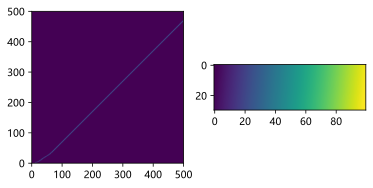

In [388]:
fig,axes = plt.subplots(1,2,figsize=(6,3))
diagonalization_ladder_overlap = np.zeros((max_ql*max_ol,max_ql*max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        if ol<max_ol-1:
            diagonalization_ladder_overlap[system.product_to_dressed[(ql,ol)],system.product_to_dressed[(ql,ol+1)]] = 1
axes[0].imshow(diagonalization_ladder_overlap,origin='lower')
# axes[0].set_xlim(0,100)
# axes[0].set_ylim(0,100)

x1 = 0
y1 = 0
axes[0].set_xlim(x1,x1+500)
axes[0].set_ylim(y1,y1+500)

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
axes[1].imshow(diagonalization_idx_arr)


(0.0, 500.0)

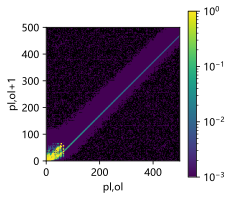

In [389]:
plt.figure(figsize=(3,3))

norm = LogNorm(vmin=1e-3,vmax=1)
cmap = mpl.colormaps['viridis']
cmap.set_bad(color='black', alpha=None)
plot_matrix(ladder_overlap,xlabel = 'pl,ol',ylabel = 'pl,ol+1',norm=norm,cmap=cmap)

# x1 = 300
# y1 = 300
plt.xlim(x1,x1+500)
plt.ylim(y1,y1+500)

In [371]:
ladder_overlap[system.product_to_dressed[(3,10)],system.product_to_dressed[(3,11)]]

0.09097580306872924

issue with going from (0, 52) to (0, 53)
issue with going from (7, 51) to (7, 52)
issue with going from (11, 21) to (11, 22)
issue with going from (16, 97) to (16, 98)
issue with going from (25, 96) to (25, 97)
issue with going from (29, 19) to (29, 20)


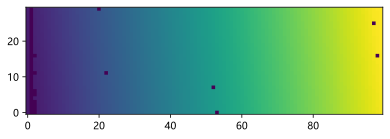

In [397]:
def find_dressed_idx_of_qubit_i_resonator_n_plus_one(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)

for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]

        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]
        if ol>=1 and ladder_overlap[system.product_to_dressed[(ql,ol-1)],system.product_to_dressed[(ql,ol)]] < np.max(ladder_overlap[system.product_to_dressed[(ql,ol-1)],:]):
            if ol>3:
                print(f"issue with going from {(ql,ol-1)} to {(ql,ol)}")
            diagonalization_idx_arr_with_marks[ql,ol] = -200
plt.imshow(diagonalization_idx_arr_with_marks,origin='lower')

# How to get the average fluxonium population? By basis changing into product state?

looping:   0%|          | 0/30 [00:00<?, ?it/s]ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
looping: 100%|██████████| 30/30 [02:53<00:00,  5.78s/it]ages/matplotlib/cbook.py: 1345


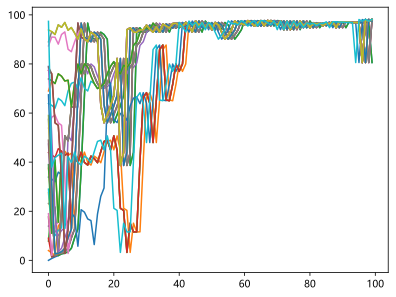

In [56]:
photon_num_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in tqdm(range(max_ql),'looping'):
    dressed_idx_arr = idx_arr[ql]
    for ol in range(max_ol):
        state_after_a = system.a.full() @ system.evecs[idx_arr[ql,ol]].full()
        photon_num_arr[ql,ol] = np.vdot(state_after_a,state_after_a)

    # Extract the relevant evecs for current ql
    evecs_for_ql = system_evecs_full[ql, idx_arr[ql]]
    
    # Compute the state after applying 'a'
    state_after_a = np.dot(system_a_full, evecs_for_ql)

    # Compute photon number using dot products
    photon_num_arr[ql] = np.einsum('ij,ij->j', state_after_a, state_after_a.conj())